# 3. 数据预处理



同样地，在第2章中，我们对人脸口罩检测数据集进行了数据探索。在本章中，我们将进行数据预处理。

热门的数据集可能包含数千甚至数万张图像，但并非所有数据集都是如此。那么，为了利用有限的数据集进行学习，我们该如何解决这一问题呢？

即便数据集不足，也没必要去寻找新的图像，这是因为利用数据增强技术可以获取处于各种不同状态的图像。

![](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/OD-ch3img01.jpeg?raw=true)

- 图3-1看起来相同但实则不同的网球（来源：https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/）

图3-1中的网球在人眼看来似乎完全一样，但深度学习模型却会将这3个网球视为各不相同的。基于这样的原理，我们可以通过对一张照片进行变换来提取出多个数据。

在3.1节中，我们将了解用于图像增强的`torchvision.transforms`和`albumentations`模块。`torchvision.transforms`是PyTorch官方提供的模块，而`albumentations`针对像`OpenCV`这类开源计算机视觉库进行了优化，所以相较于其他库，它能提供更快的处理速度以及其他功能。

上述两个模块均可用于构建图像分类模型时的增强操作。不过，用于构建对象检测模型的图像增强功能仅由`albumentations`提供。对象检测的图像增强不仅要对图像进行变换，还需要对边界框进行变形，而`torchvision.transforms`并不提供该功能。

因此，在3.2节中，我们将利用`albumentations`来实际操作边界框增强。最后，在3.3节中，我们将把数据划分为训练数据和测试数据。



## 3.1. Augmentation

对于增强实践，我们将使用第2.1节中的代码加载数据。

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 19 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.63 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=c1a4b748-d112-4b59-b874-0b70cd2d78bd
To: /content/Face Mask Detection.zip
100% 417M/417M [00:09<00:00, 45.7MB/s]
Face Mask Detection.zip download complete!


升级以使用最新版本的“albumentations”模块。您可以使用“pip install--update”命令升级特定模块。

In [2]:
!pip install --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 1 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

与第 2 章中确认过的函数存在一些不同之处。可以看到，为了后续准备用于深度学习模型学习的张量之间的运算，在generate_target函数中添加了torch.as_tensor函数。
此外，第 2 章介绍的plot_image函数是从文件路径读取图像，而plot_image_from_output函数则是对已经转换为torch.Tensor的图像进行可视化。在 PyTorch 中，图像是以[通道数，高度，宽度]的形式表示的，然而在matplotlib中，图像是以[高度，宽度，通道数]的形式表示的。因此，要利用改变通道顺序的permute函数，将其转换为matplotlib所期望的通道顺序。

### 3.1.1. Torchvision Transforms
同样地，为了对torchvision.transforms进行实践操作，我们首先来定义TorchvisionDataset类。TorchvisionDataset类会通过__getitem__方法加载图像，然后进行数据增强操作。数据增强会依据存储在transform参数中的增强规则来实施。为了进行时间测量，会使用time函数来测定时间，最后返回image、label以及total_time。

In [4]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

让我们使用“torchvision. transform”提供的功能练习图像增强。让我们创建一个大小为（300,300）的图像，然后将其裁剪为大小224。然后，让我们随机更改图像的亮度、对比度、饱和度和色调。最后，让我们应用图像左右反转，然后将其转换为张量。

In [5]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)

您可以通过变换提供的“调整大小”功能调整图像大小，并通过“随机裁剪”功能裁剪图像。“颜色抖动”功能可以任意改变亮度、对比度、饱和度、色调等。“RandomHorizontalFlip”执行左右反转，概率为p。让我们运行下面的代码来比较变化前后的图像。

transforms 적용 전


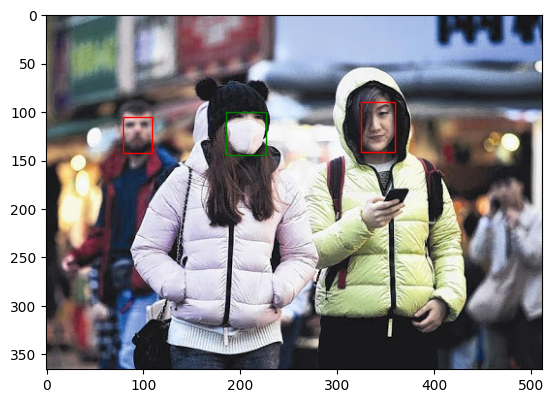

In [6]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('transforms 적용 전')
plot_image_from_output(img, annot)


transforms 적용 후


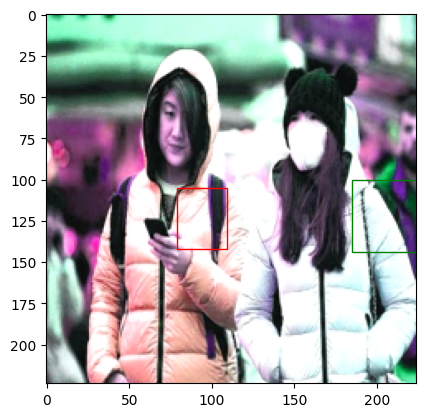

In [7]:
img, annot, transform_time = torchvision_dataset[0]

print('transforms  ')
plot_image_from_output(img, annot)

与变更前相比，可以看到变更后的图像应用了前面提到的那些变化。此外，虽然图像自身发生了变化，但能发现边界框在变化后的图像中位置出现了偏差。由此可以知道，`torchvision.transform`所提供的数据增强操作仅对图像的值进行增强，边界框并不会一起随之变换。

在图像分类问题中，即便图像发生了变化，标签值也是固定不变的；但在对象检测问题中，随着图像发生变化，标签值也必须一起改变。在3.2节中，我们将探讨解决此类问题的方法。首先，在3.1节中，我们将继续对`torchvision`和`albumentations`模块进行比较。我们将计算在`torchvision_dataset`中进行图像变换所耗费的时间，并利用下面的代码来测量将其重复100次所花费的时间。

In [8]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 21.15291118621826 ms


您可以看到执行100次图像转换大约需要10 ms~12 ms。在下一节中，我们将检查“相册”模块的增强速度。

### 3.1.2. Albumentations

在前面的 3.1.1 节中，我们已经对torchvision.transforms的转换速度进行了测量。在本节中，我们将了解另一个数据增强模块 ——albumentations。和torchvision一样，我们首先要定义数据集类。AlbumentationDataset有着与TorchVisionDataset相似的结构，它使用cv2模块读取图像并将其转换为 RGB 格式，然后对图像进行变换，最后返回变换后的结果值。

In [9]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']


        return image, target, total_time

为了与torchvision.transform进行速度比较，我们将使用与之功能相同的Resize（调整大小）、RandomCrop（随机裁剪）、ColorJitter（颜色抖动）、HorizontalFlip（水平翻转）这些功能来进行尝试。然后，我们再将图像在变更前和变更后的情况进行对比。

In [11]:
# Same transform with torchvision_transform
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1),
    albumentations.HorizontalFlip(p=1),
    albumentations.pytorch.ToTensorV2() # Changed ToTensor to ToTensorV2
])

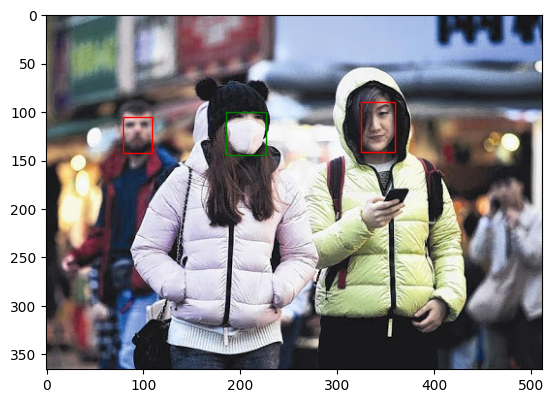

In [12]:
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

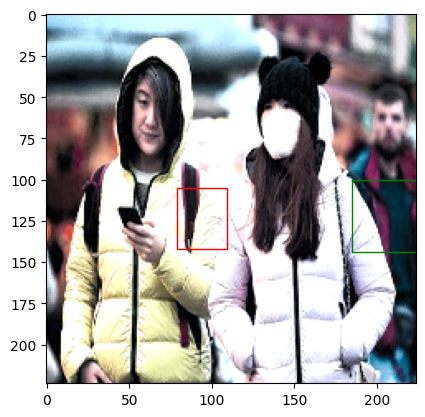

In [13]:
# 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

`torchvision.transforms`你可以看到，虽然图像转换已经完成，但边界框没有改变。用于速度测量 `albumentation`我们将在涂抹 100 次后测量时间。


In [14]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 1.6572070121765137 ms


可以看到执行100次图像转换大约需要2.0 ms~2.5 ms。与“torchvision. transform”相比，可以看到它大约快了4倍。

### 3.1.3. 基于概率的增强组合


Albumentations不仅速度比torchvision.transforms更快，还提供了新的功能。在本节中，我们将了解一下Albumentations提供的OneOf函数。该函数会基于给定的概率值来选取列表内的数据增强功能。它会综合考虑列表值本身的概率值以及该函数的概率值来决定是否执行。下面的OneOf函数中，每个功能被选中的概率都是 1。在各个函数内部的 3 个albumentations功能各自也都被赋予了概率值 1，所以实际上可以知道，是以 1/3 的概率从这 3 个功能中选择一个来执行。像这样通过调整概率值，就可以实现各种各样的数据增强了。

In [16]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)
    ], p=1),
    albumentations.pytorch.transforms.ToTensorV2() # Changed ToTensor to ToTensorV2
])

下面是albumentations_transform_oneof应用相册_图像转换 10 次_的结果

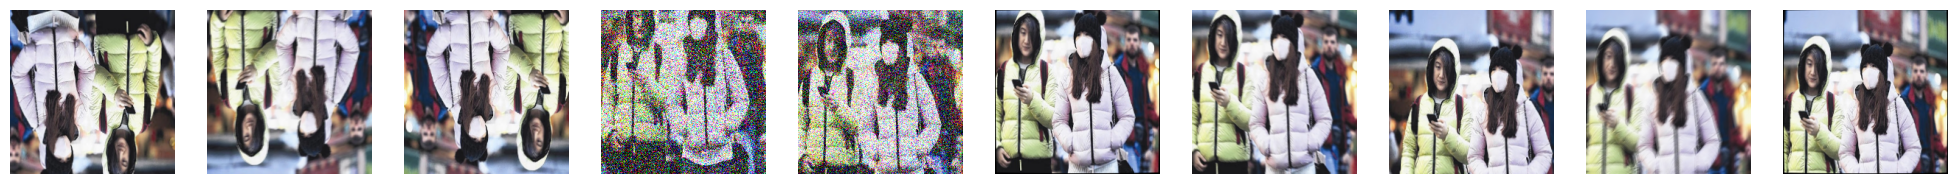

In [17]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

## 3.2.  Augmentation

在对用于构建对象检测模型的图像进行数据增强时，不仅要对图像进行变换，还需要同时对相应的边界框进行变换。正如在 3.1 节中所看到的那样，如果不一起对边界框进行变换，边界框就会检测到错误的位置，这样模型就无法正常进行学习了。利用Albumentations提供的Compose函数中的bbox_params参数，就可以实现边界框的数据增强。

In [22]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            # Convert target['labels'] to a list of integers
            target['labels'] = target['labels'].tolist()
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}


        return image, target

同样地，接下来我们将利用albumentations.Compose函数来定义变换操作。首先要进行左右翻转，在此之后，将进行在 - 90 度到 90 度之间的旋转操作。为了让边界框也能一起进行变换，要向bbox_params参数中输入albumentations.BboxParams对象。人脸口罩检测数据集的边界框标注法采用的是xmin、ymin、xmax、ymax，这与 Pascal VOC 标注法是一样的。因此，要在format参数中输入pascal_voc。此外，在进行transform操作时，为了将各个对象的类别值存储在labels参数中，要在label_field中输入labels。

In [23]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

现在我们将激活BboxAugmentationDataset类，来查看数据增强的结果。

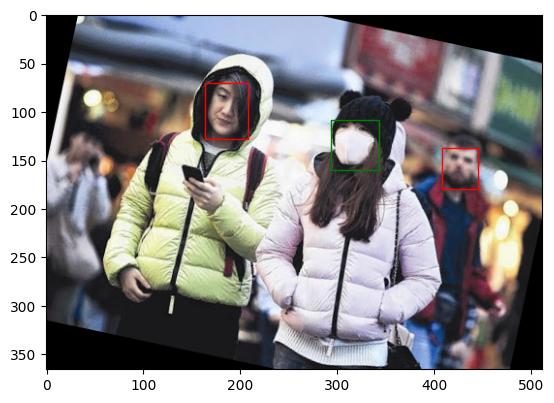

In [24]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

每次运行上述代码时，都可以看到图像经过变换后被输出。除此之外，还能看到边界框也进行了恰当的变换，能够准确地检测出变换后图像中佩戴口罩的人脸。像这样，我们将利用同时对图像和边界框进行了变换的数据，在第 4 章和第 5 章中构建模型。

## 3.3. 单独的数据

构建人工智能模型需要训练数据和测试数据，训练数据用于模型训练，测试数据用于模型评估，测试数据不应与训练数据重叠我们将3.1节加载的数据分为训练数据和测试数据，首先通过下面的代码来检查数据总数。

In [25]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


可以看到总共有 853 张图像。一般来说，学习数据和测试数据的比例为 7:3。由于这次数据的整个数据集数量较少，因此我们将采用 8:2 的比例。为了将 853 个数据中的 170 个用作测试数据，我们将把相应的数据移动到一个单独的文件夹中。首先，利用 Linux 命令 mkdir 创建一个用于存放测试数据的文件夹。

In [26]:
!mkdir test_images
!mkdir test_annotations

运行上述代码后，可以确认生成了 test_images 文件夹和 test_annotations 文件夹。现在，我们将把 images 文件夹和 annotations 文件夹中的各 170 个文件移动到新创建的文件夹中。我们将使用 random 模块中的 sample 函数随机提取数字，然后将其用作索引值。

In [27]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [28]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)



如上面的代码所示，您可以使用shutil包将170个图像和170个坐标文件分别移动到测试_图像文件夹和测试_注释文件夹。让我们检查一下每个文件夹的文件数量。

In [29]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


在图像分类问题中，划分训练用和测试用数据后，只确认图像数量即可，但在对象检测问题中，需要确认数据集中每个类别分别有多少个对象存在。下面利用代码来确认数据集中各类别对象的数量。

In [30]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train ', train_objects)
print('\n test ', test_objects)

100%|██████████| 170/170 [00:03<00:00, 47.33it/s]


 train  Counter({1: 2691, 0: 532, 2: 97})

 test  Counter({1: 541, 0: 185, 2: 26})


get_num_objects_for_each_class是一个将数据集中所有边界框的标签值存储在total_labels中，然后利用Counter类统计各标签数量并返回的函数。在训练数据中，有 532 个 0 类、2691 个 1 类、97 个 2 类；在测试数据中，有 185 个 0 类、541 个 1 类、26 个 2 类。从各数据集的 0、1、2 类比例相似这一点来看，可以确认数据已被合理划分。
到目前为止，我们了解了利用Albumentations模块对用于构建对象检测模型的图像进行扩充的方法，也了解了将现有数据划分为训练数据和测试数据的方法。在第 4 章中，我们将对单阶段模型 RetinaNet 进行训练，以此来构建口罩佩戴检测模型。